In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
# os.environ["CUDA_LAUNCH_BLOCKING"]="1";
import tensorflow as tf
#tf.config.experimental_run_functions_eagerly(True)
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import skimage
from time import time
import torch
import itertools as it
import matplotlib.patches as patches

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

C:\Users\eoind\Anaconda3\envs\proto_drive\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eoind\Anaconda3\envs\proto_drive\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\eoind\Anaconda3\envs\proto_drive\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


TF version:  2.4.1
Eager execution enabled:  False


### Loading in some data

In [2]:
x_train = np.load('x_train_mnist.npy')
x_test = np.load('x_test_mnist.npy')
y_train = np.load('y_train_mnist.npy')
y_test = np.load('y_test_mnist.npy')

prototype_indices = np.load('prototype_indices_new_method.npy')
user_indices = np.load('user_sample_indices.npy') #indices of the misclassified images presented to users from test set
misclassified_user_sample = np.array([x_test[index] for index in user_indices]) #the images themselves

In [3]:
x_train.shape

(60000, 28, 28, 1)

### Loading in the model

In [4]:
cnn=load_model('cnn_mnist.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

C:\Users\eoind\Anaconda3\envs\proto_drive\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Test accuracy:  0.9893


### Loading in some data

In [5]:
prototype_indices # indices of 20 prototypes from the training set for each class

array([[39306, 30665, 38865, 16244, 21985, 35463, 31808, 46627, 46339,
        47046,  7203,  5884, 39039, 11887, 52238, 31509, 45354, 15581,
        47172, 29732],
       [45926,  4089, 23612, 59559, 26746, 17459,  7324, 40924, 37955,
         8162, 47501, 31869, 35925, 59796, 12310, 34632, 59041, 48625,
        30261, 42546],
       [35779, 31449,  7153, 28603, 51682, 22236, 19903,  3569, 40409,
        28050, 49067, 21274, 29312, 40318, 32057,  9836, 58783, 17548,
          774, 23323],
       [ 9059, 55321, 51536, 29094,  5011, 24028, 15747, 48849, 29671,
        49810, 18992, 25949, 36946, 35548, 49494, 41143, 56337, 59914,
        40532, 56654],
       [ 3639,  7854, 11713, 47764, 50757, 35144,  2829, 18327,   275,
         6154, 37907, 11962, 54921,  3388, 24174, 42895, 23528, 54410,
        48327, 13071],
       [29049, 58290,  2328, 16582, 23792, 37049, 19022, 17645, 37552,
        47433, 22180,  3219, 31944, 23920, 40959, 11776, 45591,  7382,
        49291, 39562],
       [15

In [6]:
target_labels = [np.argmax(y_test[index]) for index in user_indices] #what the labels should be if corrected (the distractor label)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances

In [8]:
def find_nearest_prototype(image, images_array):
    # Load and preprocess the input image
    
    image = image.flatten().reshape(1, -1)
    
    images_array = images_array.reshape(images_array.shape[0], -1)

    # Calculate cosine similarity between input image and all images in array
    similarities = cosine_similarity(image, images_array)
    
    # Find index of image with highest similarity score
    nearest_index = (-(similarities.flatten())).argsort()[:3] #the top 3 most similar can change this to 1 or 2

    return nearest_index, images_array[nearest_index], similarities

### An Example

In [9]:
user_indices[0] #index of misclassified image in test set 

259

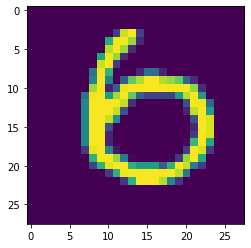

In [10]:
plt.imshow(x_test[259].reshape (28, 28))

In [11]:
np.argmax(y_test[259])

6

In [12]:
np.argmax(cnn.predict(x_test[259].reshape(1,28,28,1))) # misclassified as a 0 

0

In [13]:
similar_distractor_prototypes = []

for image, target_label in zip(misclassified_user_sample, target_labels):
    
    image = image
    images_array = np.array([x_train[index] for index in prototype_indices[target_label]])
    
#     similar_distractor_prototypes.append(find_nearest_prototype(image, images_array)[1])
    similar_distractor_prototypes.append(torch.tensor (find_nearest_prototype(image, images_array)[1][0].reshape (1, 28, 28)))
    
    

In [14]:
similar_distractor_prototypes = torch.stack (similar_distractor_prototypes);

In [15]:
np.argmax(cnn.predict(np.array(similar_distractor_prototypes)[:,0:1,:].reshape(50,28,28,1)),axis=1)

array([6, 2, 6, 8, 0, 4, 9, 3, 6, 7, 9, 7, 8, 5, 0, 3, 8, 9, 7, 4, 9, 9,
       6, 5, 6, 8, 6, 4, 7, 4, 7, 0, 6, 6, 3, 9, 4, 8, 5, 5, 9, 7, 0, 8,
       0, 8, 7, 9, 9, 2], dtype=int64)

In [16]:
np.array(target_labels)

array([6, 2, 6, 8, 0, 4, 9, 3, 6, 7, 9, 7, 8, 5, 0, 3, 8, 9, 7, 4, 9, 9,
       6, 5, 6, 8, 6, 4, 7, 4, 7, 0, 6, 6, 3, 9, 4, 8, 5, 5, 9, 7, 0, 8,
       0, 8, 7, 9, 9, 2], dtype=int64)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(np.argmax(cnn.predict(np.array(similar_distractor_prototypes)[:,0:1,:].reshape(50,28,28,1)),axis=1), np.array(target_labels))

1.0

In [19]:
distractor_prototypes = np.array(similar_distractor_prototypes)[:,0:1,:].reshape(50,28,28,1)

In [20]:
#np.save('distractor_prototypes.npy', distractor_prototypes)

## Counterfactual Generation

In [21]:
from tqdm import tqdm
from ipywidgets import FloatProgress
    
def gen_windows_spec (image, window_size_w = 7, window_size_h = 7, stride=1):
    """
    This function takes an nxn image and a window size and returns all possible windows of the given size from the image.
    """
    n = image.shape[0];
    windows = [];
    winspec = [];
    for i in range(0,n - window_size_w + 1,stride):
        for j in range(0,n - window_size_h + 1,stride):
     #       window = image[i:i + window_size, j:j + window_size];
            winspec.append((i, j, window_size_w, window_size_h))
    return winspec;

def get_a_valid_edit (img_query, img_proto, winspecs, model, target):
    print (img_query.shape)
    print (img_proto.shape)
    this_img = img_query.copy ();
    
    
    #

    #
    #
    swaps = []
    candidate_cfes = []
    with tqdm (total = len (winspecs)) as pbar:
        
        for sw, dw in winspecs:
            this_img = img_query.copy ();
            this_img[dw[0]:(dw[0] + dw[2]), dw[1]:(dw[1] + dw[3])] = img_proto[sw[0]:(sw[0] + sw[2]), sw[1]:(sw[1] + sw[3])];                                   
            this_pred = np.argmax (model.predict (this_img.reshape (1, 28, 28, 1)));
            #if this_pred == target and np.median(img_proto[sw[0]:(sw[0] + sw[2]), sw[1]:(sw[1] + sw[3])]) > -0.5:
            if this_pred == target:
                swaps.append((sw,dw))
                candidate_cfes.append(this_img)
                pbar.update (1);
            else:
                pbar.update(1)
            #return (sw, dw), this_img;
            
    #return (sw, dw), this_img;
    return swaps, candidate_cfes;

            #pbar.update (1);


In [22]:
def draw_stuff (img_query, img_prototype, edit, edited_img):
    
    _, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12,12));
    
    axes[0].imshow (img_prototype);
    rect = patches.Rectangle(
        (edit[0][1], edit[0][0]),
            edit[0][3],
            edit[0][2],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        );
    axes[0].add_patch(rect);
    axes[0].get_xaxis().set_ticks([]);
    axes[0].get_yaxis().set_ticks([]);
    
    axes[1].imshow (img_query);
    rect = patches.Rectangle(
        (edit[1][1], edit[1][0]),
            edit[1][3],
            edit[1][2],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        );
    
    axes[1].add_patch(rect);
    axes[1].get_xaxis().set_ticks([]);
    axes[1].get_yaxis().set_ticks([]);

    axes[2].imshow (edited_img);


+ mis_img is the one which is misclassified
+ proto_img is the prototype (distractor)
+ target_cls is the class which we want to achieve

In [23]:
index = 8
mis_img = misclassified_user_sample[index].reshape (28, 28);
proto_img = similar_distractor_prototypes[index:index+1].numpy ().reshape (28, 28);
target_cls = np.array(target_labels)[index];

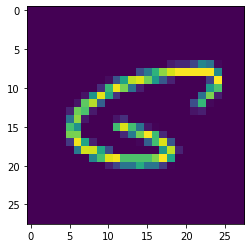

In [24]:
plt.imshow(mis_img)

winspecs means window specification. Each tuple has the starting row and column in the image, and the width and height, respectively.

In [25]:
winspecs = gen_windows_spec (misclassified_user_sample[index], window_size_w = 14, window_size_h = 14,stride=7);

In [26]:
winspecs

[(0, 0, 14, 14),
 (0, 7, 14, 14),
 (0, 14, 14, 14),
 (7, 0, 14, 14),
 (7, 7, 14, 14),
 (7, 14, 14, 14),
 (14, 0, 14, 14),
 (14, 7, 14, 14),
 (14, 14, 14, 14)]

winspec_maps is just combination of the window specifications. So, as we are try,ing to map one box in the source to all possible boxes in the destination, we do a cartecian product. So the a tuple ((0, 0, 6, 12), (5, 15, 6, 12)) means the source image's starting coord (0,0) with a width of 6 and height of 12, will map into the destination box starting at coord (5, 16) and width 6 and height 12.

In [27]:
winspec_maps = list (it.product (winspecs, winspecs))

This returns the first encountered valid change. trans_spec is the two tuple as explained above, which identifies the source and destination box specifications. The trans_img, is the result edited image.

In [28]:
trans_spec, trans_img = get_a_valid_edit (mis_img, proto_img, winspec_maps, cnn, target_cls)

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 67/81 [00:00<00:00, 340.88it/s]

(28, 28)
(28, 28)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 310.71it/s]


In [29]:
winspecs #visualizing

[(0, 0, 14, 14),
 (0, 7, 14, 14),
 (0, 14, 14, 14),
 (7, 0, 14, 14),
 (7, 7, 14, 14),
 (7, 14, 14, 14),
 (14, 0, 14, 14),
 (14, 7, 14, 14),
 (14, 14, 14, 14)]

### Lets create the for Loop

In [30]:
winspecs = gen_windows_spec (misclassified_user_sample[index], window_size_w = 7, window_size_h = 7,stride=7);
winspec_maps = list (it.product (winspecs, winspecs));

swaps = []
candidate_cfes = []

for index in range((misclassified_user_sample).shape[0]):
    
    index = index
    mis_img = misclassified_user_sample[index].reshape (28, 28);
    proto_img = similar_distractor_prototypes[index:index+1].numpy ().reshape (28, 28);
    target_cls = np.array(target_labels)[index];
    swap, candidate_cfe = get_a_valid_edit (mis_img, proto_img, winspec_maps, cnn, target_cls)
    
    if len(candidate_cfe) != 0:
        swaps.append(swap)
        candidate_cfes.append(candidate_cfe)
        
    else:
        candidate_cfes.append(proto_img.reshape(1,28,28)) #worst case scenario return the prototype
        swaps.append(0)

 13%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                            | 33/256 [00:00<00:00, 315.12it/s]

(28, 28)
(28, 28)


 16%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                | 40/256 [00:00<00:00, 394.06it/s]

(28, 28)
(28, 28)


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                            | 99/256 [00:00<00:00, 502.36it/s]

(28, 28)
(28, 28)


 21%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                          | 53/256 [00:00<00:00, 526.96it/s]

(28, 28)
(28, 28)


 21%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                        | 54/256 [00:00<00:00, 504.57it/s]

(28, 28)
(28, 28)


 21%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                       | 55/256 [00:00<00:00, 546.51it/s]

(28, 28)
(28, 28)


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                          | 109/256 [00:00<00:00, 541.45it/s]

(28, 28)
(28, 28)


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                           | 118/256 [00:00<00:00, 579.56it/s]

(28, 28)
(28, 28)


 23%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                  | 58/256 [00:00<00:00, 571.78it/s]

(28, 28)
(28, 28)


 24%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                            | 61/256 [00:00<00:00, 609.10it/s]

(28, 28)
(28, 28)


 24%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                           | 62/256 [00:00<00:00, 618.79it/s]

(28, 28)
(28, 28)


 27%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                               | 69/256 [00:00<00:00, 626.70it/s]

(28, 28)
(28, 28)


 27%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                               | 69/256 [00:00<00:00, 627.35it/s]

(28, 28)
(28, 28)


 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                       | 64/256 [00:00<00:00, 582.89it/s]

(28, 28)
(28, 28)


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 123/256 [00:00<00:00, 612.32it/s]

(28, 28)
(28, 28)


 26%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                  | 67/256 [00:00<00:00, 610.21it/s]

(28, 28)
(28, 28)


 23%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                  | 58/256 [00:00<00:00, 573.82it/s]

(28, 28)
(28, 28)


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                            | 108/256 [00:00<00:00, 525.93it/s]

(28, 28)
(28, 28)


 23%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                  | 58/256 [00:00<00:00, 576.46it/s]

(28, 28)
(28, 28)


 25%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                         | 63/256 [00:00<00:00, 607.23it/s]

(28, 28)
(28, 28)


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 123/256 [00:00<00:00, 603.00it/s]

(28, 28)
(28, 28)


 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                 | 68/256 [00:00<00:00, 621.13it/s]

(28, 28)
(28, 28)


 22%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                   | 57/256 [00:00<00:00, 566.22it/s]

(28, 28)
(28, 28)


 25%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                      | 65/256 [00:00<00:00, 592.39it/s]

(28, 28)
(28, 28)


 24%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                           | 62/256 [00:00<00:00, 563.95it/s]

(28, 28)
(28, 28)


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                          | 128/256 [00:00<00:00, 600.56it/s]

(28, 28)
(28, 28)


 24%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                           | 62/256 [00:00<00:00, 618.95it/s]

(28, 28)
(28, 28)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                           | 127/256 [00:00<00:00, 597.20it/s]

(28, 28)
(28, 28)


 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                       | 64/256 [00:00<00:00, 637.29it/s]

(28, 28)
(28, 28)


 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                 | 68/256 [00:00<00:00, 616.18it/s]

(28, 28)
(28, 28)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                        | 129/256 [00:00<00:00, 608.98it/s]

(28, 28)
(28, 28)


 24%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                           | 62/256 [00:00<00:00, 562.85it/s]

(28, 28)
(28, 28)


 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                       | 64/256 [00:00<00:00, 583.97it/s]

(28, 28)
(28, 28)


 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                 | 68/256 [00:00<00:00, 619.43it/s]

(28, 28)
(28, 28)


 23%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                | 59/256 [00:00<00:00, 530.76it/s]

(28, 28)
(28, 28)


 24%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                            | 61/256 [00:00<00:00, 609.02it/s]

(28, 28)
(28, 28)


 26%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                    | 66/256 [00:00<00:00, 600.28it/s]

(28, 28)
(28, 28)


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                      | 130/256 [00:00<00:00, 619.32it/s]

(28, 28)
(28, 28)


 21%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                       | 55/256 [00:00<00:00, 549.93it/s]

(28, 28)
(28, 28)


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                            | 117/256 [00:00<00:00, 576.95it/s]

(28, 28)
(28, 28)


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                      | 121/256 [00:00<00:00, 610.39it/s]

(28, 28)
(28, 28)


 23%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                              | 60/256 [00:00<00:00, 597.68it/s]

(28, 28)
(28, 28)


 23%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                  | 58/256 [00:00<00:00, 528.35it/s]

(28, 28)
(28, 28)


 20%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                              | 51/256 [00:00<00:00, 484.10it/s]

(28, 28)
(28, 28)


 22%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                     | 56/256 [00:00<00:00, 559.02it/s]

(28, 28)
(28, 28)


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                               | 106/256 [00:00<00:00, 524.80it/s]

(28, 28)
(28, 28)


 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                       | 64/256 [00:00<00:00, 611.67it/s]

(28, 28)
(28, 28)


 27%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                               | 69/256 [00:00<00:00, 626.12it/s]

(28, 28)
(28, 28)


 23%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                  | 58/256 [00:00<00:00, 578.85it/s]

(28, 28)
(28, 28)


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                              | 116/256 [00:00<00:00, 540.37it/s]

(28, 28)
(28, 28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 576.97it/s]


In [31]:
for index in range(50):
    print(np.array(candidate_cfes[index]).shape)

(83, 28, 28)
(47, 28, 28)
(17, 28, 28)
(27, 28, 28)
(35, 28, 28)
(33, 28, 28)
(19, 28, 28)
(36, 28, 28)
(1, 28, 28)
(8, 28, 28)
(14, 28, 28)
(80, 28, 28)
(31, 28, 28)
(22, 28, 28)
(7, 28, 28)
(78, 28, 28)
(16, 28, 28)
(5, 28, 28)
(100, 28, 28)
(73, 28, 28)
(8, 28, 28)
(39, 28, 28)
(32, 28, 28)
(23, 28, 28)
(15, 28, 28)
(59, 28, 28)
(46, 28, 28)
(121, 28, 28)
(21, 28, 28)
(31, 28, 28)
(59, 28, 28)
(30, 28, 28)
(44, 28, 28)
(44, 28, 28)
(20, 28, 28)
(18, 28, 28)
(39, 28, 28)
(59, 28, 28)
(65, 28, 28)
(89, 28, 28)
(11, 28, 28)
(30, 28, 28)
(1, 28, 28)
(6, 28, 28)
(1, 28, 28)
(36, 28, 28)
(15, 28, 28)
(9, 28, 28)
(8, 28, 28)
(30, 28, 28)


In [32]:
#np.array(candidate_cfes[0])

In [33]:
from skimage.metrics import structural_similarity

In [34]:
cfe = []
swap_index = []
for index in range(50):

    sims = []


    for image in np.array(candidate_cfes[index]):

        sims.append(structural_similarity(distractor_prototypes[index].reshape(28,28),image.reshape(28,28)))

    cfe.append(candidate_cfes[index][np.argmax(np.array(sims))])
    swap_index.append(np.argmax(np.array(sims)))
    
    


In [35]:
#np.save('protoguide_cfes.npy', np.array(cfe).reshape(50,28,28,1))

In [36]:
similar_distractor_prototypes[27:27+1].numpy ().reshape (28, 28)

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5   

In [37]:
swap_index[37]

23

In [38]:
reversed(swaps[38][swap_index[38]])

In [39]:
len(swaps)

50

In [40]:
def draw_stuff (img_query, img_prototype, edit, edited_img, filename):
    
    _, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12,12));
    
    axes[1].imshow (img_prototype);
    rect = patches.Rectangle(
        (edit[0][1], edit[0][0]),
            edit[0][3],
            edit[0][2],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        );
    axes[1].add_patch(rect);
    axes[1].get_xaxis().set_ticks([]);
    axes[1].get_yaxis().set_ticks([]);
    
    axes[0].imshow (img_query);
    rect = patches.Rectangle(
        (edit[1][1], edit[1][0]),
            edit[1][3],
            edit[1][2],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        );
    
    axes[0].add_patch(rect);
    axes[0].get_xaxis().set_ticks([]);
    axes[0].get_yaxis().set_ticks([]);

    axes[2].imshow (edited_img);
    axes[2].get_xaxis().set_ticks([]);
    axes[2].get_yaxis().set_ticks([]);
    
    
    axes[0].title.set_text('Misclassified Query')
    axes[1].title.set_text('Prototype In \nCounterfactual Class')
    axes[2].title.set_text('ProtoGuide \nCounterfactual')
    
    #plt.savefig(filename)


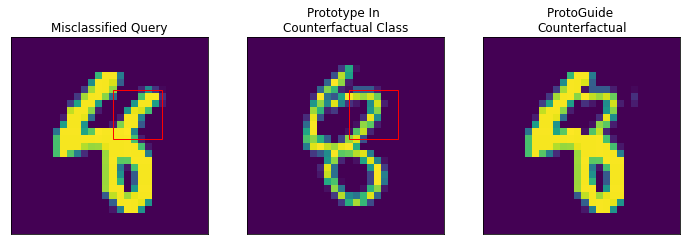

In [41]:
draw_stuff(misclassified_user_sample[37], similar_distractor_prototypes[37:37+1].numpy ().reshape (28, 28), swaps[37][swap_index[37]], cfe[37], 'protoguide_ex3.pdf')